In [1]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize
from clapton.ansatzes import * 
from clapton.clifford import ParametrizedCliffordCircuit
import numpy as np
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_qec.utils.stim_tools import get_stim_circuits
from qiskit_research.utils.convenience import *

In [2]:
paulis = ["XXI", "IXX", "YYI", "IYY", "ZZI", "IZZ"]
coeffs = np.random.random(len(paulis))

from clapton.depolarization import GateGeneralDepolarizationModel #TODO: check this out 


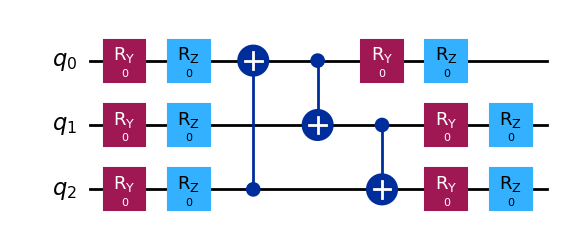

In [3]:
def circular_ansatz(N, reps=1, fix_2q=False):
    pcirc = QuantumCircuit(N)
    for _ in range(reps):
        for i in range(N):
            pcirc.ry(0,i)
        for i in range(N):
            pcirc.rz(0,i)
        for i in range(N):
            control = (i-1) % N
            target = i
            if fix_2q:
                pcirc.cx(control, target).fix(1)
            else:
                pcirc.cx(control, target)
    for i in range(N):
        pcirc.ry(0,i)
    for i in range(N):
        pcirc.rz(0,i)
    return pcirc

qc=circular_ansatz(3)
qc.draw(output='mpl')

## Altering the Ansatz itself

In [4]:
rng = np.random.default_rng()

TWIRL_GATES_CX = (
        (('I', 'I'), ('I', 'I')),
        (('I', 'X'), ('I', 'X')),
        (('I', 'Y'), ('Z', 'Y')),
        (('I', 'Z'), ('Z', 'Z')),
        (('X', 'I'), ('X', 'X')),
        (('X', 'X'), ('X', 'I')),
        (('X', 'Y'), ('Y', 'Z')),
        (('X', 'Z'), ('Y', 'Y')),
        (('Y', 'I'), ('Y', 'X')),
        (('Y', 'X'), ('Y', 'I')),
        (('Y', 'Y'), ('X', 'Z')),
        (('Y', 'Z'), ('X', 'Y')),
        (('Z', 'I'), ('Z', 'I')),
        (('Z', 'X'), ('Z', 'X')),
        (('Z', 'Y'), ('I', 'Y')),
        (('Z', 'Z'), ('I', 'Z')),
    )

pauli_twirl_dict = {"I":0,"X":1,"Y":2,"Z":3}

def twirled_circular_ansatz(N, reps=1, fix_2q=False):
    pcirc = ParametrizedCliffordCircuit()
    for _ in range(reps):
        for i in range(N):
            pcirc.RY(i)
        for i in range(N):
            pcirc.RZ(i)
        for i in range(N):
            control = (i-1) % N
            target = i
            if fix_2q:
                
                (before0, before1), (after0, after1) = TWIRL_GATES_CX[
                    rng.integers(len(TWIRL_GATES_CX))]

                pcirc.PauliTwirl(control).fix(pauli_twirl_dict[before0])
                pcirc.PauliTwirl(control).fix(pauli_twirl_dict[before1])
                pcirc.Q2(control, target).fix(1)
                pcirc.PauliTwirl(target).fix(pauli_twirl_dict[after0])
                pcirc.PauliTwirl(target).fix(pauli_twirl_dict[after1])
            else:
                pcirc.Q2(control, target)
    for i in range(N):
        pcirc.RY(i)
    for i in range(N):
        pcirc.RZ(i)

    
    return pcirc

pauli_twirl_list = [twirled_circular_ansatz(N=len(paulis[0]), reps=1, fix_2q=True) for _ in range(100)]


In [5]:
pauli_twirl_list[0].stim_circuit().diagram()

q0: -I-I-----X-I-X-Z-X-@-------------I-I---
             |         |
q1: -I-I-----|---------X-Z-X-Y-Z-@---I-I---
             |                   |
q2: -I-I-I-X-@-------------------X-X-Y-I-I-

In [6]:
twirl_ansatz = twirled_circular_ansatz(N=len(paulis[0]), reps=1, fix_2q=True)

# let's add a noise model where we specify global 1q and 2q gate errors
nm = GateGeneralDepolarizationModel(p1=0.005, p2=0.02)
twirl_ansatz.add_depolarization_model(nm)
# twirl_ansatz.add_pauli_twirl_list(pauli_twirl_list)s


In [7]:
twirl_ansatz.number_parametrized_gates()

12

In [8]:
twirl_ansatz.read()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
twirl_ansatz.stim_circuit().diagram()

q0: -I-DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)---------------------------------------------------------------------------------X-DEPOLARIZE2(0.02)-Y-DEPOLARIZE1(0.005)-X-DEPOLARIZE1(0.005)-X-DEPOLARIZE1(0.005)-Z-DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.02)--------------------------------------------------------------------------------------------------------------------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)---------------------------------------
                                                                                                                                                                   | |                                                                                                     | |
q1: ---I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)--------------------------------------------------------------|-|-----------------------------------------------------------------------------------------------------X-DEPOLARIZE2(0.02)-Y-DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)-Z-DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.02)-------------------------------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)--------------------
                                                                                                                                                                   | |                                                                                                                                                                                                             | |
q2: ----------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)-I-DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.02)---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------X-DEPOLARIZE2(0.02)-I-DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)-

In [10]:
ks_best, energy_noisy, energy_noiseless = claptonize(
    paulis,
    coeffs,
    twirl_ansatz,
    n_proc=4,           # total number of processes in parallel
    n_starts=4,         # number of random genetic algorithm starts in parallel
    n_rounds=1,         # number of budget rounds, if None it will terminate itself
    callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
    budget=20,                        # budget per genetic algorithm instance
)

STARTING ROUND 0


started GA at id 1 with 1 procs

started GA at id None with 1 procs




/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evo

started GA at id 2 with 1 procs


/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



started GA at id 3 with 1 procs


/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


[0, array([-0.03506725, -0.03506725,  0.        ,  0.        ]), array([1, 0, 1, 3, 0, 1, 2, 3, 3, 3, 1, 2], dtype=object)]
[0, array([0.62988427, 0.27914695, 0.35073732, 0.        ]), array([0, 1, 0, 2, 2, 3, 1, 3, 3, 1, 3, 0], dtype=object)][0, array([-0.69154489, -0.3438289 , -0.347716  ,  0.        ]), array([2, 1, 3, 2, 2, 2, 2, 0, 3, 1, 0, 0], dtype=object)][0, array([-0.68834721, -0.33760989, -0.35073732,  0.        ]), array([0, 0, 2, 3, 2, 2, 1, 0, 1, 0, 0, 1], dtype=object)]


[1, array([0.62403302, 0.2732957 , 0.35073732, 0.        ]), array([3, 1, 1, 1, 1, 3, 0, 3, 0, 3, 2, 1], dtype=object)]
[1, array([-0.6880889 , -0.33735157, -0.35073732,  0.        ]), array([0, 3, 3, 0, 3, 3, 2, 3, 0, 3, 3, 1], dtype=object)]
[1, array([-0.03059781, -0.03059781,  0.        ,  0.        ]), array([3, 3, 3, 0, 2, 1, 1, 1, 3, 2, 0, 0], dtype=object)]
[1, array([-0.70101655, -0.35330055, -0.347716  ,  0.        ]), array([3, 1, 3, 1, 2, 0, 1, 1, 1, 2, 0, 1], dtype=object)]
[2, array([0.625

In [11]:
ks_best

[2, 3, 0, 2, 2, 2, 3, 0, 1, 1, 0, 1]

In [12]:
energy_noisy, energy_noiseless

(0.018802974936390753, 0.0)

In [13]:
# differrence
np.abs(energy_noisy-energy_noiseless)

0.018802974936390753

In [14]:
# the corresponding circuit is
twirl_ansatz.assign(ks_best)
twirl_ansatz.snapshot_noiseless().circ_snapshot_noiseless.diagram()

q0: -Y----------Z-----X-Y-X-X-Z-@-------------SQRT_Y_DAG-S--------
                      |         |
q1: -SQRT_Y_DAG-Z-----|---------X-Y-Y-Z-Y-@---I----------I--------
                      |                   |
q2: -I----------Z-Y-I-@-------------------X-I-Y----------SQRT_Y-S-